## 1.Installing and importing required libraries

In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install geocoder
!conda install -c conda-forge geopy --yes

     |████████████████████████████████| 122kB 10.3MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 9.6MB/s eta 0:00:01
     |████████████████████████████████| 102kB 8.6MB/s ta 0:00:011
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/n

In [2]:
import numpy as np
import pandas as pd
import requests # library for handling requests
from bs4 import BeautifulSoup # library to parsing HTML documents
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

## 2.Downloading and Scraping the required data

In [3]:
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [4]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
table=soup.find('table',{'class':"wikitable"})
table

<table class="wikitable sortable">
<tbody><tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A
</td>
<td>North York
</td>
<td>Parkwoods
</td></tr>
<tr>
<td>M4A
</td>
<td>North York
</td>
<td>Victoria Village
</td></tr>
<tr>
<td>M5A
</td>
<td>Downtown Toronto
</td>
<td>Regent Park, Harbourfront
</td></tr>
<tr>
<td>M6A
</td>
<td>North York
</td>
<td>Lawrence Manor, Lawrence Heights
</td></tr>
<tr>
<td>M7A
</td>
<td>Downtown Toronto
</td>
<td>Queen's Park, Ontario Provincial Government
</td></tr>
<tr>
<td>M8A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M9A
</td>
<td>Etobicoke
</td>
<td>Islington Avenue, Humber Valley Village
</td></tr>
<tr>
<td>M1B
</td>
<td>Scarborough
</td>
<td>Malvern, Rouge
</td></tr>
<tr>
<td>M2B
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3B
</td>
<td

In [5]:
df=pd.read_html(str(table))
# convert list to dataframe
df=pd.DataFrame(df[0])
print(df.head())
df.shape

  Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront


(180, 3)

## 3.Data Cleaning

In [6]:
df=df[df['Borough']!='Not assigned']
df=df.reset_index(drop=True)
df.sort_values(by=['Postal Code'], inplace=True)
df

,Postal Code,Borough,Neighbourhood
6,M1B,Scarborough,"Malvern, Rouge"
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
18,M1E,Scarborough,"Guildwood, Morningside, West Hill"
22,M1G,Scarborough,Woburn
26,M1H,Scarborough,Cedarbrae
...,...,...,...
64,M9N,York,Weston
70,M9P,Etobicoke,Westmount
77,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
89,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [7]:
df.shape

(103, 3)

In [8]:
df["Neighbourhood"]= df["Neighbourhood"].str.split(", ") 
df=df.explode("Neighbourhood").reset_index(drop=True)
df.loc[df['Postal Code'] == 'M5A']
df.shape

(217, 3)

In [9]:
geospat_df=pd.read_csv("https://cocl.us/Geospatial_data")
geospat_df

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [10]:
df_merge=pd.merge(df,geospat_df,on='Postal Code')
df_merge

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Malvern,43.806686,-79.194353
1,M1B,Scarborough,Rouge,43.806686,-79.194353
2,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
3,M1C,Scarborough,Port Union,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497
...,...,...,...,...,...
212,M9V,Etobicoke,Beaumond Heights,43.739416,-79.588437
213,M9V,Etobicoke,Thistletown,43.739416,-79.588437
214,M9V,Etobicoke,Albion Gardens,43.739416,-79.588437
215,M9W,Etobicoke,Northwest,43.706748,-79.594054


In [11]:
toronto_new = df_merge[df_merge['Borough'].str.contains("Toronto")]
toronto_new=toronto_new.reset_index(drop=True)
toronto_new.sort_values(by=['Postal Code'], inplace=True)
toronto_new

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,The Danforth West,43.679557,-79.352188
2,M4K,East Toronto,Riverdale,43.679557,-79.352188
3,M4L,East Toronto,India Bazaar,43.668999,-79.315572
4,M4L,East Toronto,The Beaches West,43.668999,-79.315572
...,...,...,...,...,...
73,M6S,West Toronto,Swansea,43.651571,-79.484450
74,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
75,M7A,Downtown Toronto,Ontario Provincial Government,43.662301,-79.389494
76,M7Y,East Toronto,Business reply mail Processing Centre,43.662744,-79.321558


In [12]:
CLIENT_ID = '5SI1P1B0VV2SNDCPPOW5LUDUUCKPHP1FLT4FVFF5UFDHIJF5' # your Foursquare ID
CLIENT_SECRET = 'VSKZAMBDRWAMHPXXL0EN4U2ONC3RJ1PKIPTWBQLGIF2MXXQU' # your Foursquare Secret
VERSION = '20201127' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5SI1P1B0VV2SNDCPPOW5LUDUUCKPHP1FLT4FVFF5UFDHIJF5
CLIENT_SECRET:VSKZAMBDRWAMHPXXL0EN4U2ONC3RJ1PKIPTWBQLGIF2MXXQU


In [13]:
search_query='Restaurant'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=toronto_new['Neighbourhood'],
                                   latitudes=toronto_new['Latitude'],
                                   longitudes=toronto_new['Longitude']
                                  )

The Beaches
The Danforth West
Riverdale
India Bazaar
The Beaches West
Studio District
Lawrence Park
Davisville North
Lawrence Park
North Toronto West
Davisville
Moore Park
Summerhill East
Summerhill West
Rathnelly
South Hill
Forest Hill SE
Deer Park
Rosedale
St. James Town
Cabbagetown
Church and Wellesley
Regent Park
Harbourfront
Garden District
Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond
Adelaide
King
Harbourfront East
Union Station
Toronto Islands
Toronto Dominion Centre
Design Exchange
Victoria Hotel
Commerce Court
Roselawn
Forest Hill North & West
Forest Hill Road Park
The Annex
North Midtown
Yorkville
University of Toronto
Harbord
Grange Park
Kensington Market
Chinatown
South Niagara
CN Tower
King and Spadina
Railway Lands
Harbourfront West
Bathurst Quay
Island airport
Stn A PO Boxes
First Canadian Place
Underground city
Christie
Dufferin
Dovercourt Village
Little Portugal
Trinity
Exhibition Place
Parkdale Village
Brockton
High Park
The Junction South
Parkdale
R

In [15]:
toronto_venues.head()
#toronto_venues['Venue Category'].unique() 
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Restaurant']


In [16]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Adelaide,84,84,84,84,84,84
Bathurst Quay,2,2,2,2,2,2
Berczy Park,43,43,43,43,43,43
Brockton,13,13,13,13,13,13
Business reply mail Processing Centre,4,4,4,4,4,4
...,...,...,...,...,...,...
Underground city,91,91,91,91,91,91
Union Station,65,65,65,65,65,65
University of Toronto,26,26,26,26,26,26


In [17]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Danforth West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Adelaide,0.0,0.047619,0.0,0.0,0.071429,0.000000,0.011905,0.035714,0.000000,...,0.047619,0.011905,0.0,0.000000,0.047619,0.0,0.0,0.035714,0.000000,0.0
1,Bathurst Quay,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,Berczy Park,0.0,0.023256,0.0,0.0,0.023256,0.000000,0.023256,0.093023,0.023256,...,0.069767,0.000000,0.0,0.023256,0.023256,0.0,0.0,0.046512,0.000000,0.0
3,Brockton,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.153846,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.076923,0.0
4,Business reply mail Processing Centre,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Underground city,0.0,0.065934,0.0,0.0,0.043956,0.000000,0.000000,0.043956,0.000000,...,0.043956,0.010989,0.0,0.000000,0.021978,0.0,0.0,0.010989,0.000000,0.0
72,Union Station,0.0,0.015385,0.0,0.0,0.000000,0.000000,0.000000,0.015385,0.000000,...,0.015385,0.000000,0.0,0.000000,0.015385,0.0,0.0,0.015385,0.000000,0.0
73,University of Toronto,0.0,0.000000,0.0,0.0,0.000000,0.038462,0.000000,0.076923,0.000000,...,0.038462,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.076923,0.000000,0.0
74,Victoria Hotel,0.0,0.056180,0.0,0.0,0.033708,0.000000,0.000000,0.044944,0.000000,...,0.022472,0.011236,0.0,0.000000,0.033708,0.0,0.0,0.033708,0.000000,0.0


### Getting top 10 venues of each neighbourhood

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Café,Asian Restaurant,Salad Place,American Restaurant,Thai Restaurant,Sandwich Place,Sushi Restaurant,Steakhouse,Burger Joint,Bakery
1,Bathurst Quay,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,Berczy Park,Bakery,Sushi Restaurant,Italian Restaurant,Bistro,Café,Greek Restaurant,Diner,Seafood Restaurant,Moroccan Restaurant,Vegetarian / Vegan Restaurant
3,Brockton,Café,Breakfast Spot,Bakery,Vietnamese Restaurant,Italian Restaurant,Japanese Restaurant,Sandwich Place,Burrito Place,Fast Food Restaurant,Doner Restaurant
4,Business reply mail Processing Centre,Fast Food Restaurant,Burrito Place,Pizza Place,Gastropub,Fried Chicken Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### K Means clustering of neighbourhood based on the common Venue Category

In [21]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 1, 4, 2, 1, 1, 1, 1], dtype=int32)

In [22]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_new

#merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Burger Joint,Asian Restaurant,Pizza Place,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,M4K,East Toronto,The Danforth West,43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Caribbean Restaurant,Tibetan Restaurant,American Restaurant,Mediterranean Restaurant,Bakery
2,M4K,East Toronto,Riverdale,43.679557,-79.352188,1,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Caribbean Restaurant,Tibetan Restaurant,American Restaurant,Mediterranean Restaurant,Bakery
3,M4L,East Toronto,India Bazaar,43.668999,-79.315572,1,Fast Food Restaurant,Pizza Place,Italian Restaurant,Fish & Chips Shop,Sushi Restaurant,Steakhouse,Sandwich Place,Fried Chicken Joint,Dumpling Restaurant,Cuban Restaurant
4,M4L,East Toronto,The Beaches West,43.668999,-79.315572,1,Fast Food Restaurant,Pizza Place,Italian Restaurant,Fish & Chips Shop,Sushi Restaurant,Steakhouse,Sandwich Place,Fried Chicken Joint,Dumpling Restaurant,Cuban Restaurant


In [23]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=np.nan_to_num(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

In [25]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Central Toronto,0,Italian Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
12,Central Toronto,0,Italian Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant


In [26]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Burger Joint,Asian Restaurant,Pizza Place,Wings Joint,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,East Toronto,1,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Caribbean Restaurant,Tibetan Restaurant,American Restaurant,Mediterranean Restaurant,Bakery
2,East Toronto,1,Greek Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Burger Joint,Caribbean Restaurant,Tibetan Restaurant,American Restaurant,Mediterranean Restaurant,Bakery
3,East Toronto,1,Fast Food Restaurant,Pizza Place,Italian Restaurant,Fish & Chips Shop,Sushi Restaurant,Steakhouse,Sandwich Place,Fried Chicken Joint,Dumpling Restaurant,Cuban Restaurant
4,East Toronto,1,Fast Food Restaurant,Pizza Place,Italian Restaurant,Fish & Chips Shop,Sushi Restaurant,Steakhouse,Sandwich Place,Fried Chicken Joint,Dumpling Restaurant,Cuban Restaurant
5,East Toronto,1,Pizza Place,Bakery,Café,Gastropub,American Restaurant,Seafood Restaurant,Italian Restaurant,Thai Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant
6,Central Toronto,1,Fast Food Restaurant,Bagel Shop,Diner,Chinese Restaurant,Café,Seafood Restaurant,Mexican Restaurant,Dim Sum Restaurant,Italian Restaurant,Food Court
7,Central Toronto,1,Asian Restaurant,Pizza Place,Breakfast Spot,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
9,Central Toronto,1,Fast Food Restaurant,Bagel Shop,Diner,Chinese Restaurant,Café,Seafood Restaurant,Mexican Restaurant,Dim Sum Restaurant,Italian Restaurant,Food Court
8,Central Toronto,1,Fast Food Restaurant,Mexican Restaurant,Diner,Chinese Restaurant,Italian Restaurant,Bagel Shop,Café,Seafood Restaurant,Doner Restaurant,Donut Shop


In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
50,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
51,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
52,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
53,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
54,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
56,Downtown Toronto,2,American Restaurant,Tapas Restaurant,Wings Joint,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant


In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Central Toronto,3,Pizza Place,American Restaurant,Vietnamese Restaurant,Fried Chicken Joint,Bagel Shop,Sushi Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
14,Central Toronto,3,Pizza Place,American Restaurant,Vietnamese Restaurant,Fried Chicken Joint,Bagel Shop,Sushi Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
15,Central Toronto,3,Pizza Place,American Restaurant,Vietnamese Restaurant,Fried Chicken Joint,Bagel Shop,Sushi Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
16,Central Toronto,3,Pizza Place,American Restaurant,Vietnamese Restaurant,Fried Chicken Joint,Bagel Shop,Sushi Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
17,Central Toronto,3,Pizza Place,American Restaurant,Vietnamese Restaurant,Fried Chicken Joint,Bagel Shop,Sushi Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
40,Central Toronto,3,French Restaurant,Sushi Restaurant,Wings Joint,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
41,Central Toronto,3,French Restaurant,Sushi Restaurant,Wings Joint,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Central Toronto,4,Fast Food Restaurant,Greek Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
76,East Toronto,4,Fast Food Restaurant,Burrito Place,Pizza Place,Gastropub,Fried Chicken Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
77,East Toronto,4,Fast Food Restaurant,Burrito Place,Pizza Place,Gastropub,Fried Chicken Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


In [30]:
clusterdata = pd.merge(toronto_onehot.groupby('Neighbourhood').sum(),toronto_merged[['Neighbourhood','Cluster Labels']],left_on='Neighbourhood', right_on='Neighbourhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0,1,2,3,4
Afghan Restaurant,0,1,0,0,0
American Restaurant,0,65,7,5,0
Arepa Restaurant,0,3,0,0,0
Argentinian Restaurant,0,2,0,0,0
Asian Restaurant,0,56,0,0,0


In [31]:
import seaborn as sns
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df1 = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df1.index, y=clusternumber, data=df1)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

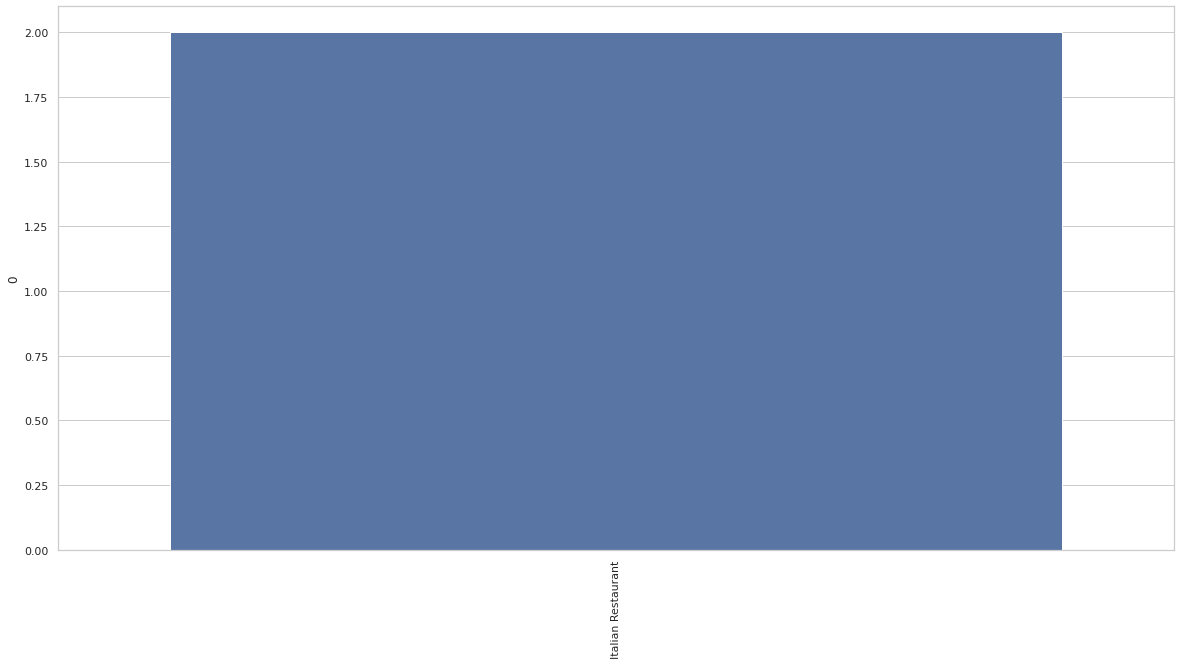

In [32]:
plot_bar(0)

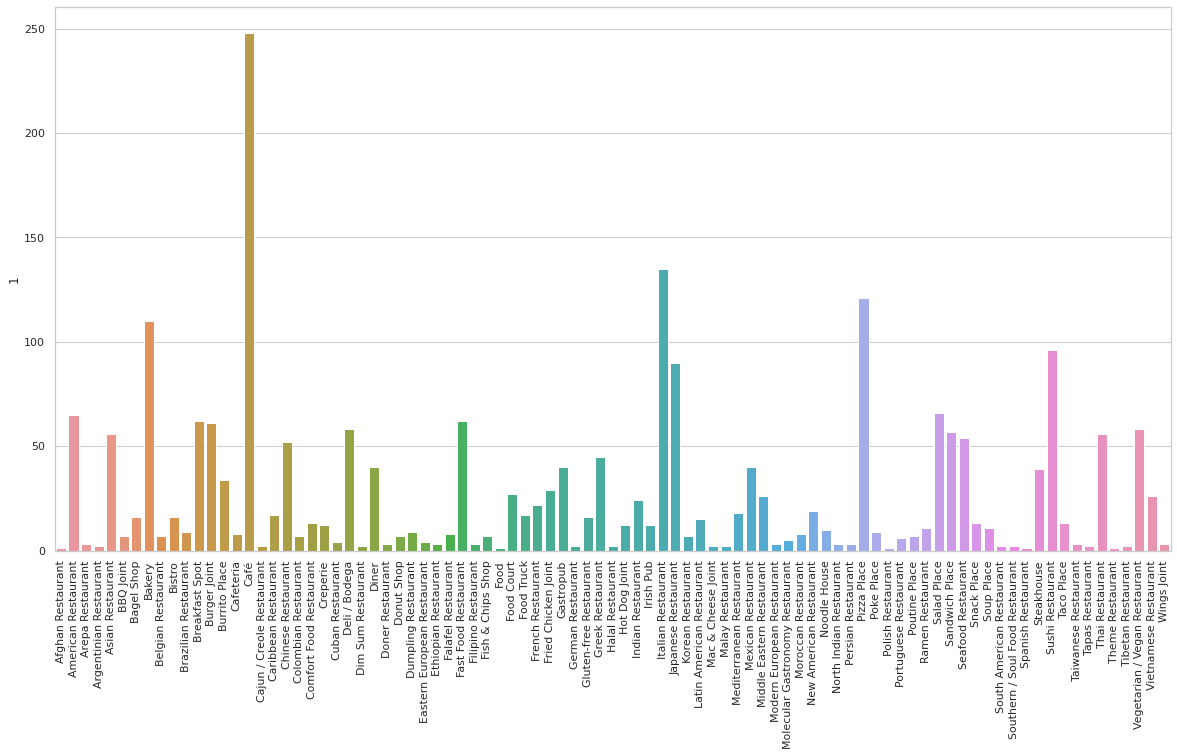

In [33]:
plot_bar(1)

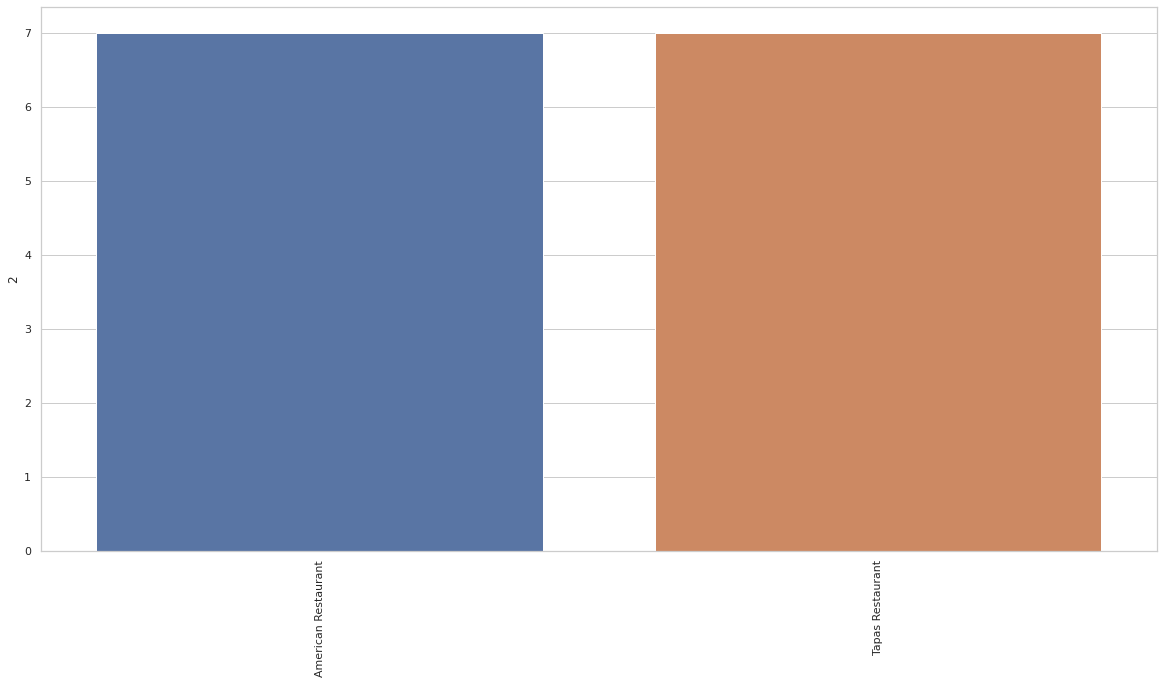

In [34]:
plot_bar(2)

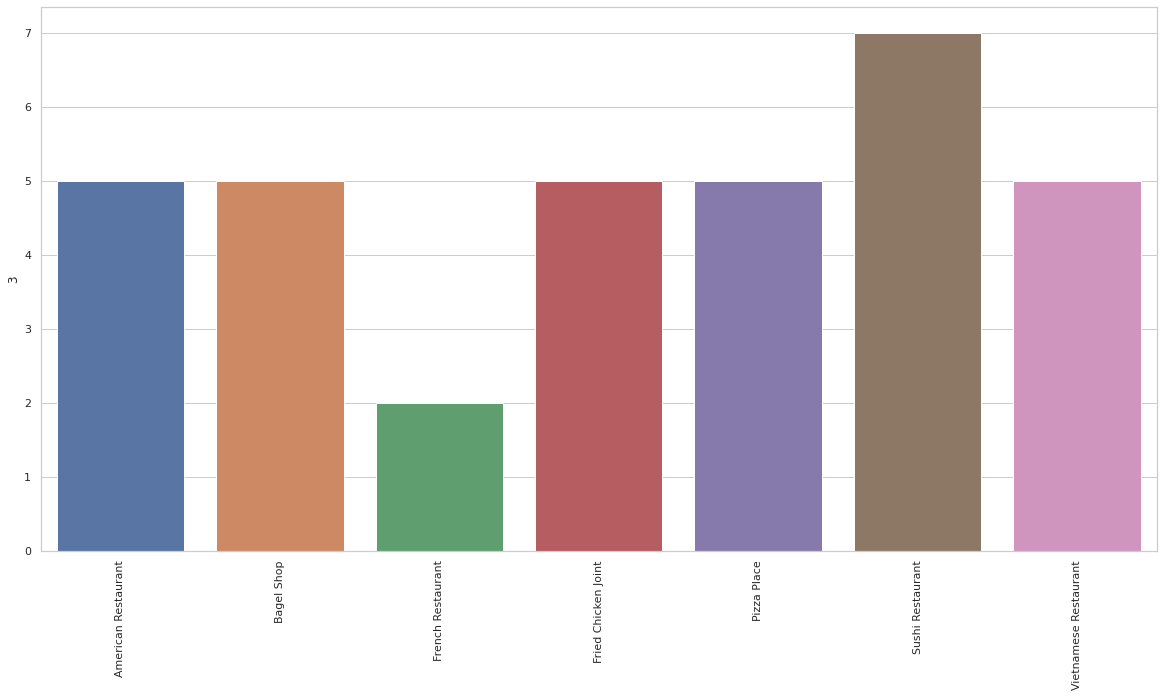

In [35]:
plot_bar(3)

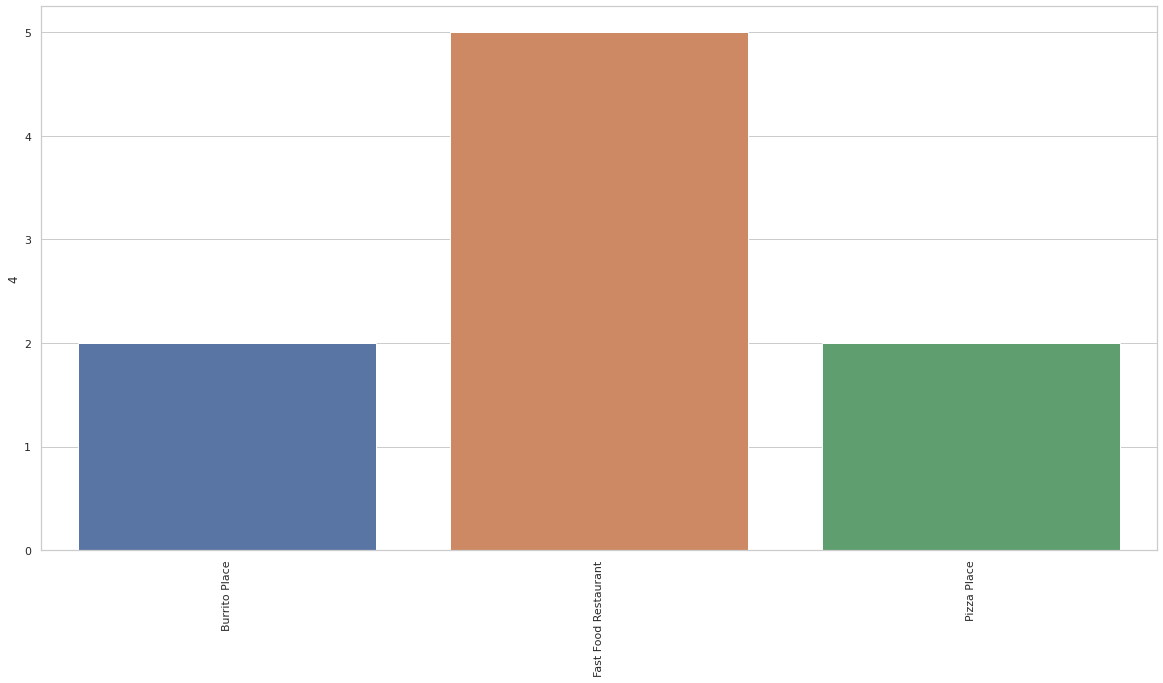

In [36]:
plot_bar(4)

In [37]:
forheatmap=toronto_venues.copy()
forheatmap=pd.merge(forheatmap,toronto_merged[['Neighbourhood','Cluster Labels']],left_on='Neighbourhood', right_on='Neighbourhood',how='inner')
forheatmap.drop(forheatmap[~forheatmap['Cluster Labels'].isin([1,2])].index, inplace=True)

In [38]:
forheatmap.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,The Beaches,43.676357,-79.293031,Domino's Pizza,43.679058,-79.297382,Pizza Place,1
1,The Beaches,43.676357,-79.293031,Fearless Meat,43.680337,-79.290289,Burger Joint,1
2,The Beaches,43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant,1
3,The Danforth West,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,1
4,The Danforth West,43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,1


In [39]:
from folium.plugins import HeatMap

In [40]:
#heat map of all restaurants in selected Neighborhoods
res_heat = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forheatmap['Venue Latitude'],forheatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(forheatmap['Neighbourhood Latitude'], forheatmap['Neighbourhood Longitude'], forheatmap['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)

res_heat

In [41]:
forpizzaplace = forheatmap[forheatmap['Venue Category']=='Pizza Place']

# heat map for Pizza Places in the selected Neighborhoods
res_heat_piz = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forpizzaplace['Venue Latitude'],forpizzaplace['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat_piz)
for lat, lng, label in zip(forpizzaplace['Neighbourhood Latitude'], forpizzaplace['Neighbourhood Longitude'], forpizzaplace['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat_piz)
res_heat_piz

In this section,we will filter out neighbourhoods that have density of pizza places greater than 30 percentile and density of restaurants greater than 60% and make final recommendation based on it.

In [42]:
count_all = forheatmap[['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue')
target_count = int(0.6*len(count_all))
print(count_all.iloc[target_count])
count_all.drop(count_all[count_all.Venue.values>7].index,inplace=True)
count_all.columns=['all count']
count_all.head()

Venue    35
Name: The Danforth West, dtype: int64


,all count
Neighbourhood,
Rosedale,1
Island airport,2
Harbourfront West,2
King and Spadina,2
South Niagara,2


In [43]:
count_piz_place = forheatmap[forheatmap['Venue Category']=="Pizza Place"][['Neighbourhood','Venue']].groupby('Neighbourhood').count().sort_values(by='Venue')
target_count = int(0.3*len(count_piz_place))
print(count_piz_place.iloc[target_count])
count_piz_place.drop(count_piz_place[count_piz_place.Venue.values>1].index,inplace=True)
count_piz_place.columns = ['piz place count']
count_piz_place.head()

Venue    2
Name: The Beaches West, dtype: int64


,piz place count
Neighbourhood,
Parkdale,1
The Beaches,1
The Annex,1
Roncesvalles,1
North Midtown,1


In [44]:
lowdensity = count_all.join(count_piz_place)
lowdensity.index.values

array(['Rosedale', 'Island airport', 'Harbourfront West',
       'King and Spadina', 'South Niagara', 'Railway Lands',
       'Bathurst Quay', 'CN Tower', 'Davisville North', 'The Beaches',
       'Christie', 'Roncesvalles', 'Parkdale'], dtype=object)

In [45]:
final_recommend = toronto_new.copy()
final_recommend.drop(final_recommend[~final_recommend['Neighbourhood'].isin(lowdensity.index.values)].index, inplace=True)
final_recommend.head()


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
7,M4P,Central Toronto,Davisville North,43.712751,-79.390197
18,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
55,M5V,Downtown Toronto,South Niagara,43.628947,-79.394420
50,M5V,Downtown Toronto,CN Tower,43.628947,-79.394420


In [46]:
final = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final_recommend['Latitude'], final_recommend['Longitude'], final_recommend['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(final)  
    
final